In [13]:
# Cell 1: Initialize libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

# Reproducibility
RANDOM_STATE = 39




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    average_precision_score,
    make_scorer
)

from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

from model import FraudDetector

# Notebook autoreload
%load_ext autoreload
%autoreload 2

# For reproducibility
RANDOM_STATE = 39

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Cell 2: Load and prepare dataset
df = pd.read_csv("historical.csv")

# Target = outcome, drop tid if present
X = df.drop(columns=["outcome", "tid"]) if "tid" in df.columns else df.drop(columns=["outcome"])
y = df["outcome"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Fraud ratio (train):", y_train.mean())


Train size: (148099, 29) Test size: (37025, 29)
Fraud ratio (train): 0.0017285734542434453


In [15]:
# Cell: Randomized Search for SMOTE + Tomek parameters (separate steps)

# Build pipeline with separate steps
pipeline_smote_tomek = Pipeline([
    ('smote', SMOTE(random_state=39)),
    ('tomek', TomekLinks()),
    ('clf', RandomForestClassifier(
        random_state=39,
        n_estimators=500,
        n_jobs=-1
    ))
])

# Parameter search space (only for SMOTE)
param_distributions = {
    'smote__sampling_strategy': [0.2, 0.3],
    'smote__k_neighbors': [3, 5, 7, 9, 11],
}

# Cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=39)

# Randomized search (optimize recall)
random_search = RandomizedSearchCV(
    estimator=pipeline_smote_tomek,
    param_distributions=param_distributions,
    n_iter=10,                 # increase for deeper search
    scoring=make_scorer(recall_score),
    n_jobs=-1,
    cv=cv,
    random_state=39,
    verbose=2
)

# Fit random search
random_search.fit(X_train, y_train)

# Apply best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate metrics
precision_smote_tomek = precision_score(y_test, y_pred)
recall_smote_tomek = recall_score(y_test, y_pred)
f1_smote_tomek = f1_score(y_test, y_pred)

print("Best SMOTE Params:", random_search.best_params_)
print(f"Precision: {precision_smote_tomek:.4f}")
print(f"Recall:    {recall_smote_tomek:.4f}")
print(f"F1 Score:  {f1_smote_tomek:.4f}")



# Plot curves
plt.figure(figsize=(10,6))
plt.plot(thresholds, recalls, marker='o', label="Recall")
plt.plot(thresholds, precisions, marker='o', label="Precision")
plt.plot(thresholds, f1s, marker='o', label="F1 Score")

plt.axhline(0.90, color='red', linestyle='--', label="Target Recall = 0.90")

plt.title("SMOTE + Tomek: Precision, Recall, and F1 vs. Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 5.0min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 5.6min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 5.7min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 5.9min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 6.0min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 6.2min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.3; total time= 6.3min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.3; total time= 6.4min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.3; total time= 6.4min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.3; total time= 6.5min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.3; total time= 6.5min
[CV] END .smote__k_neighbors=5, smote__sampling_

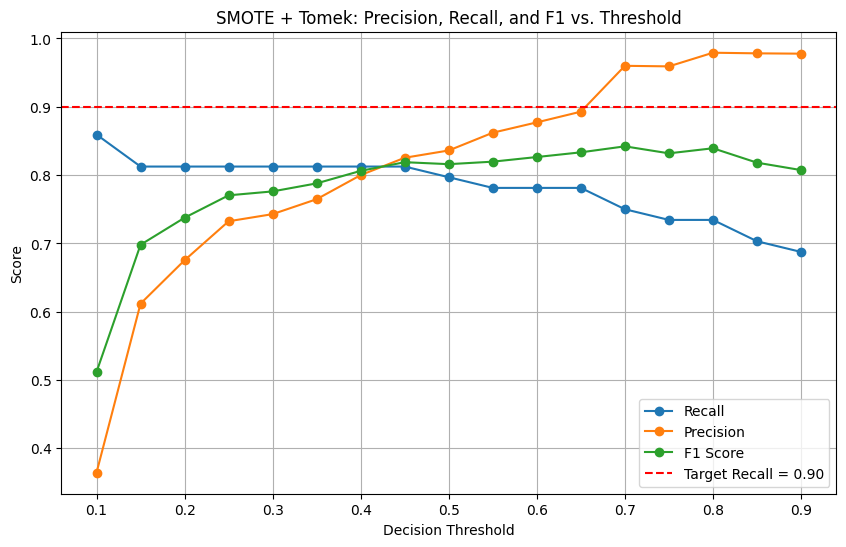

In [16]:
# Get predicted probabilities from best model
y_proba = best_model.predict_proba(X_test)[:, 1]

# Sweep thresholds
thresholds = np.arange(0.1, 0.91, 0.05)
recalls, precisions, f1s = [], [], []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_thresh))

# Plot curves
plt.figure(figsize=(10,6))
plt.plot(thresholds, recalls, marker='o', label="Recall")
plt.plot(thresholds, precisions, marker='o', label="Precision")
plt.plot(thresholds, f1s, marker='o', label="F1 Score")

plt.axhline(0.90, color='red', linestyle='--', label="Target Recall = 0.90")

plt.title("SMOTE + Tomek: Precision, Recall, and F1 vs. Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Smote Grid-Search
pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=39)),
    ('clf', RandomForestClassifier(
        random_state=39,
        n_estimators=500,
        n_jobs=-1
    ))
])

param_grid = {
    'smote__sampling_strategy': [0.2, 0.3],
    'smote__k_neighbors': [3, 5, 7, 9, 11],
}

grid_search = GridSearchCV(
    estimator=pipeline_smote,
    param_grid=param_grid,
    scoring=make_scorer(recall_score),
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Params:", grid_search.best_params_)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 4.6min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 4.7min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 4.8min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.2; total time= 4.8min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.3; total time= 4.9min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.3; total time= 5.0min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.3; total time= 5.1min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 5.1min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.2; total time= 5.1min
[CV] END .smote__k_neighbors=3, smote__sampling_strategy=0.3; total time= 5.2min
[CV] END .smote__k_neighbors=5, smote__sampling_strategy=0.3; total time= 5.4min
[CV] END .smote__k_neighbors=5, smote__sampling_

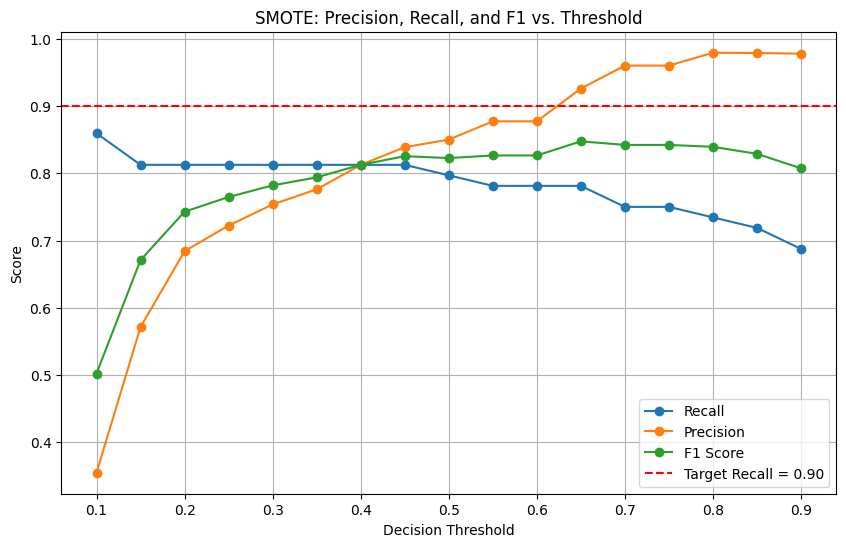

In [18]:
# Get predicted probabilities from best model
y_proba = best_model.predict_proba(X_test)[:, 1]

# Sweep thresholds
thresholds = np.arange(0.1, 0.91, 0.05)
recalls, precisions, f1s = [], [], []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_thresh))

# Plot curves
plt.figure(figsize=(10,6))
plt.plot(thresholds, recalls, marker='o', label="Recall")
plt.plot(thresholds, precisions, marker='o', label="Precision")
plt.plot(thresholds, f1s, marker='o', label="F1 Score")

plt.axhline(0.90, color='red', linestyle='--', label="Target Recall = 0.90")

plt.title("SMOTE: Precision, Recall, and F1 vs. Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()
